In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import gensim
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data/movie_info.csv')
df = df.rename(columns={"locale_id": "local_id"})
df.head()

,local_id,title,id_imdb,genre_imdb
0,1,Toy Story (1995),tt0114709,Animation|Adventure|Comedy|Family|Fantasy
1,2,GoldenEye (1995),tt0113189,Action|Adventure|Thriller
2,3,Four Rooms (1995),tt0113101,Comedy
3,4,Get Shorty (1995),tt0113161,Comedy|Crime|Thriller
4,5,Copycat (1995),tt0112722,Drama|Mystery|Thriller


In [3]:
synopsis_data = pd.read_json('data/movie_synopsis.json')
synopsis_data = synopsis_data.transpose()
synopsis_data.head()

,imdbID,plot_synopsis,local_id,plot_source
1,tt0114709,A boy called Andy Davis (voice: John Morris) u...,1,imdb
2,tt0113189,"The story opens in 1986, in the Cold War Sovie...",2,imdb
3,tt0113101,The film begins with Ted the Bellhop (Tim Roth...,3,imdb
4,tt0113161,Chilli Palmer (John Travolta) is a loan shark ...,4,imdb
5,tt0112722,After giving a guest lecture on criminal psych...,5,imdb


In [4]:
movie_df = pd.merge(df, synopsis_data, on='local_id')
movie_df = movie_df.drop(['id_imdb'], axis=1)
movie_df.head()

,local_id,title,genre_imdb,imdbID,plot_synopsis,plot_source
0,1,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,tt0114709,A boy called Andy Davis (voice: John Morris) u...,imdb
1,2,GoldenEye (1995),Action|Adventure|Thriller,tt0113189,"The story opens in 1986, in the Cold War Sovie...",imdb
2,3,Four Rooms (1995),Comedy,tt0113101,The film begins with Ted the Bellhop (Tim Roth...,imdb
3,4,Get Shorty (1995),Comedy|Crime|Thriller,tt0113161,Chilli Palmer (John Travolta) is a loan shark ...,imdb
4,5,Copycat (1995),Drama|Mystery|Thriller,tt0112722,After giving a guest lecture on criminal psych...,imdb


In [5]:
movie_df['plot_synopsis'] = movie_df['plot_synopsis'].str.lower()
movie_df['tokenized'] = movie_df['plot_synopsis'].apply(lambda x : nltk.word_tokenize(x))
movie_df.head()

,local_id,title,genre_imdb,imdbID,plot_synopsis,plot_source,tokenized
0,1,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,tt0114709,a boy called andy davis (voice: john morris) u...,imdb,"[a, boy, called, andy, davis, (, voice, :, joh..."
1,2,GoldenEye (1995),Action|Adventure|Thriller,tt0113189,"the story opens in 1986, in the cold war sovie...",imdb,"[the, story, opens, in, 1986, ,, in, the, cold..."
2,3,Four Rooms (1995),Comedy,tt0113101,the film begins with ted the bellhop (tim roth...,imdb,"[the, film, begins, with, ted, the, bellhop, (..."
3,4,Get Shorty (1995),Comedy|Crime|Thriller,tt0113161,chilli palmer (john travolta) is a loan shark ...,imdb,"[chilli, palmer, (, john, travolta, ), is, a, ..."
4,5,Copycat (1995),Drama|Mystery|Thriller,tt0112722,after giving a guest lecture on criminal psych...,imdb,"[after, giving, a, guest, lecture, on, crimina..."


In [6]:
movie_df['tokenized'] = movie_df['tokenized'].apply(
                            lambda x : [w for w in x if w not in stopwords.words('english')])
stemmer = LancasterStemmer()
movie_df['tokenized'] = movie_df['tokenized'].apply(
                            lambda x : [stemmer.stem(w) for w in x])

In [7]:
movie_df.head()

,local_id,title,genre_imdb,imdbID,plot_synopsis,plot_source,tokenized
0,1,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,tt0114709,a boy called andy davis (voice: john morris) u...,imdb,"[boy, cal, andy, dav, (, voic, :, john, mor, )..."
1,2,GoldenEye (1995),Action|Adventure|Thriller,tt0113189,"the story opens in 1986, in the cold war sovie...",imdb,"[story, op, 1986, ,, cold, war, soviet, un, .,..."
2,3,Four Rooms (1995),Comedy,tt0113101,the film begins with ted the bellhop (tim roth...,imdb,"[film, begin, ted, bellhop, (, tim, roth, ), r..."
3,4,Get Shorty (1995),Comedy|Crime|Thriller,tt0113161,chilli palmer (john travolta) is a loan shark ...,imdb,"[chill, palm, (, john, travolt, ), loan, shark..."
4,5,Copycat (1995),Drama|Mystery|Thriller,tt0112722,after giving a guest lecture on criminal psych...,imdb,"[giv, guest, lect, crimin, psycholog, loc, uni..."


In [8]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')',
                         '-', '_', '+', '=', ',', '.', ':', ';', '"', '?', '~']
movie_df['tokenized'] = movie_df['tokenized'].apply(lambda x : [w for w in x if w not in special_chars])
movie_df.head()

,local_id,title,genre_imdb,imdbID,plot_synopsis,plot_source,tokenized
0,1,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,tt0114709,a boy called andy davis (voice: john morris) u...,imdb,"[boy, cal, andy, dav, voic, john, mor, us, toy..."
1,2,GoldenEye (1995),Action|Adventure|Thriller,tt0113189,"the story opens in 1986, in the cold war sovie...",imdb,"[story, op, 1986, cold, war, soviet, un, brit,..."
2,3,Four Rooms (1995),Comedy,tt0113101,the film begins with ted the bellhop (tim roth...,imdb,"[film, begin, ted, bellhop, tim, roth, room, f..."
3,4,Get Shorty (1995),Comedy|Crime|Thriller,tt0113161,chilli palmer (john travolta) is a loan shark ...,imdb,"[chill, palm, john, travolt, loan, shark, liv,..."
4,5,Copycat (1995),Drama|Mystery|Thriller,tt0112722,after giving a guest lecture on criminal psych...,imdb,"[giv, guest, lect, crimin, psycholog, loc, uni..."


In [9]:
doc_list = movie_df['tokenized'].tolist()

In [10]:
def tagged_document(list_of_list_words):
    for i, list_of_words in enumerate(list_of_list_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [11]:
data_for_training = list(tagged_document(doc_list))

In [12]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=3, epochs=50)

In [13]:
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
doc_vec_list = []
for doc in doc_list:
    doc_vec_list.append(model.infer_vector(doc))
doc_df = pd.DataFrame(doc_vec_list, dtype=float)
doc_df['genre'] = movie_df['genre_imdb']
doc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,genre
0,-2.647339,-0.257766,-6.962307,2.861124,-0.834988,3.592825,-3.010619,-3.986681,-3.481984,-4.853828,...,3.126859,-3.824336,-2.878156,-3.149217,4.297006,4.042799,-3.720547,-0.933504,-0.256440,Animation|Adventure|Comedy|Family|Fantasy
1,-2.954717,4.077096,0.976622,-5.446016,-2.179845,-0.655529,10.558377,1.628892,-3.944371,1.419454,...,0.748296,5.093925,1.998877,-1.655298,0.316790,5.210764,3.189064,3.146582,-0.928617,Action|Adventure|Thriller
2,-5.957631,3.035388,0.148440,0.273425,3.349509,0.129359,4.889817,0.177565,-1.444126,-0.592202,...,1.062745,3.459220,0.014899,3.514898,2.167164,2.320045,-1.399501,5.997634,-0.315733,Comedy
3,1.847090,0.907842,-6.159061,-4.279135,-1.478494,-0.628495,-1.175499,1.346726,-2.369323,-1.333129,...,1.203959,-0.106084,2.833294,1.706303,0.710071,1.148314,-1.205044,-0.665707,0.946404,Comedy|Crime|Thriller
4,-4.315137,-2.093809,1.878052,-0.652726,-0.952639,-2.483120,0.071023,-0.897404,-1.223734,-0.899137,...,0.071346,0.409605,-0.950966,1.824379,1.075976,-1.174630,-0.462861,0.258820,-0.111210,Drama|Mystery|Thriller


In [15]:
X = doc_df.drop('genre', axis=1)
y = doc_df['genre']

In [16]:
scale = StandardScaler()
X_norm = scale.fit_transform(X)
print(X_norm.shape)

(1681, 100)


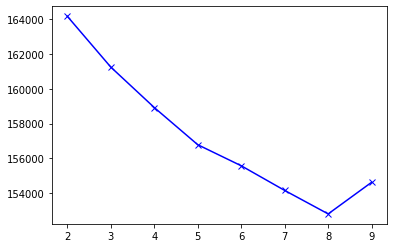

In [17]:
cost = [np.nan, np.nan]
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X_norm)
    cost.append(kmeans.inertia_)
plt.plot(cost, 'bx-')

In [18]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_norm)
kmeans_labels = kmeans.labels_

In [19]:
pca = PCA(3)
pca.fit(X_norm)
X_PCA = pca.transform(X_norm)
print(X_PCA.shape)

(1681, 3)


In [20]:
x_pca, y_pca, z_pca = X_PCA[:, 0], X_PCA[:, 1], X_PCA[:, 2]
colors = {0: 'red',
          1: 'blue',
          2: 'green',
          3: 'yellow',
          4: 'orange',
          5: 'purple',
          6: 'pink',
          7: 'gray',
          8: 'brown'}
pca_df = pd.DataFrame({'x': x_pca, 'y': y_pca, 'z': z_pca, 'label': kmeans_labels})
groups = pca_df.groupby('label')

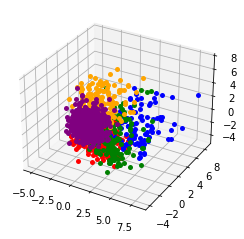

In [21]:
# fig, ax = plt.subplots(figsize=(6, 6))
ax = plt.axes(projection='3d')
for name, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=5, color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    ax.tick_params(axis='z', which='both', left='off', top='off', labelleft='off')
plt.show()

In [22]:
doc_df['cluster_label'] = kmeans_labels
doc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,genre,cluster_label
0,-2.647339,-0.257766,-6.962307,2.861124,-0.834988,3.592825,-3.010619,-3.986681,-3.481984,-4.853828,...,-3.824336,-2.878156,-3.149217,4.297006,4.042799,-3.720547,-0.933504,-0.256440,Animation|Adventure|Comedy|Family|Fantasy,4
1,-2.954717,4.077096,0.976622,-5.446016,-2.179845,-0.655529,10.558377,1.628892,-3.944371,1.419454,...,5.093925,1.998877,-1.655298,0.316790,5.210764,3.189064,3.146582,-0.928617,Action|Adventure|Thriller,1
2,-5.957631,3.035388,0.148440,0.273425,3.349509,0.129359,4.889817,0.177565,-1.444126,-0.592202,...,3.459220,0.014899,3.514898,2.167164,2.320045,-1.399501,5.997634,-0.315733,Comedy,4
3,1.847090,0.907842,-6.159061,-4.279135,-1.478494,-0.628495,-1.175499,1.346726,-2.369323,-1.333129,...,-0.106084,2.833294,1.706303,0.710071,1.148314,-1.205044,-0.665707,0.946404,Comedy|Crime|Thriller,4
4,-4.315137,-2.093809,1.878052,-0.652726,-0.952639,-2.483120,0.071023,-0.897404,-1.223734,-0.899137,...,0.409605,-0.950966,1.824379,1.075976,-1.174630,-0.462861,0.258820,-0.111210,Drama|Mystery|Thriller,0


In [23]:
genres = doc_df['genre'].tolist()
genres_set = {}
for i, g in enumerate(genres):
    for a_g in str(g).split('|'):
        if a_g not in genres_set:
            genres_set[a_g] = {i: 0 for i in range(n_clusters)}
        else:
            genres_set[a_g][kmeans_labels[i]] += 1
genres_set.pop('nan')
print(genres_set)

{'Animation': {0: 3, 1: 2, 2: 25, 3: 1, 4: 3, 5: 7}, 'Adventure': {0: 49, 1: 41, 2: 76, 3: 3, 4: 12, 5: 34}, 'Comedy': {0: 100, 1: 10, 2: 52, 3: 74, 4: 81, 5: 318}, 'Family': {0: 13, 1: 5, 2: 57, 3: 2, 4: 15, 5: 66}, 'Fantasy': {0: 20, 1: 5, 2: 60, 3: 3, 4: 16, 5: 38}, 'Action': {0: 128, 1: 43, 2: 26, 3: 12, 4: 14, 5: 20}, 'Thriller': {0: 190, 1: 39, 2: 11, 3: 31, 4: 52, 5: 59}, 'Crime': {0: 164, 1: 2, 2: 4, 3: 34, 4: 50, 5: 56}, 'Drama': {0: 179, 1: 31, 2: 93, 3: 133, 4: 101, 5: 447}, 'Mystery': {0: 52, 1: 11, 2: 11, 3: 15, 4: 32, 5: 27}, 'History': {0: 6, 1: 5, 2: 22, 3: 8, 4: 1, 5: 14}, 'Romance': {0: 33, 1: 3, 2: 56, 3: 54, 4: 48, 5: 256}, 'Sci-Fi': {0: 30, 1: 46, 2: 15, 3: 1, 4: 14, 5: 13}, 'War': {0: 8, 1: 16, 2: 19, 3: 7, 4: 0, 5: 24}, 'Music': {0: 5, 1: 1, 2: 2, 3: 14, 4: 10, 5: 26}, 'Horror': {0: 38, 1: 10, 2: 18, 3: 3, 4: 18, 5: 13}, 'Musical': {0: 3, 1: 0, 2: 27, 3: 2, 4: 5, 5: 21}, 'Biography': {0: 11, 1: 4, 2: 14, 3: 14, 4: 4, 5: 36}, 'Documentary': {0: 0, 1: 1, 2: 1, 3: 3

In [24]:
summary_dict = {}
for g, labels in genres_set.items():
    total_count = 0
    for i in range(n_clusters):
        total_count += labels[i]
        
    if total_count >= 80:
        summary_dict[g] = []
        for i in range(n_clusters):
            if labels[i] / total_count > 0.25:
                summary_dict[g].append(i)
print(summary_dict)

{'Adventure': [2], 'Comedy': [5], 'Family': [2, 5], 'Fantasy': [2, 5], 'Action': [0], 'Thriller': [0], 'Crime': [0], 'Drama': [5], 'Mystery': [0], 'Romance': [5], 'Sci-Fi': [0, 1], 'Horror': [0], 'Biography': [5]}


In [25]:
summary_cluster = {i: [] for i in range(n_clusters)}
for genre, lst in summary_dict.items():
    for c in lst:
        summary_cluster[c].append(genre)
print(summary_cluster)

{0: ['Action', 'Thriller', 'Crime', 'Mystery', 'Sci-Fi', 'Horror'], 1: ['Sci-Fi'], 2: ['Adventure', 'Family', 'Fantasy'], 3: [], 4: [], 5: ['Comedy', 'Family', 'Fantasy', 'Drama', 'Romance', 'Biography']}
